# K-najbliższych-sąsiadów (K-nearest-neighbours)
Celem ćwiczenia jest uzyskanie wiedzy o tym jak działa algorytm k-najbliższych sąsiadów. Napiszemy go od podstaw i wykorzystamy na zbiorze danych 'Iris'

# Proces

Ćwiczenie składa się z następujących kroków
1. pobranie zbioru danych
2. przekonwertowanie do formatu pandas-friendly
3. podzielenie zbioru na część testową i uczącą
4. zdefiniowanie metryki odległości - wykorzystamy euklidesową
5. napisanie funkcji szukającej najbliższych sąsiadów dla zadanego przypadku
6. predykcja gatunku irysa dla każdej obserwacji w zbiorze uczącym i ocena błędu klasyfikacji
7. predykcja gatunku irysa dla każdej obserwacji w zbiorze testowym
8. analiza macierzy błędów (confusion matrix)
9. analiza błędu testowego dla różnych parametrów k

#### Zaimportowanie odpowiednich bibliotek

In [1]:
import pandas as pd
import numpy as np
# usuńmy notację naukową
np.set_printoptions(suppress=True)
# format danych numerycznych
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Pobranie zbioru danych
Na początku potrzebujemy danych. Możemy wykorzystać jeden ze zbiorów dostępnych domyślnie w pakiecie sklearn. W tym notebooku będzie to jedyne miejsce, gdzie wykorzystamy ten pakiet ;)

In [2]:
from sklearn import datasets

In [3]:
iris = datasets.load_iris()

Możemy uzyskać dane za pomocą właściwości .data. Zmienna objaśniana (gatunek poszczególnej obserwacji) jest dostępna przez właściwość .target

In [4]:
iris.data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [5]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## 2. Konwersja zbioru danych do formatu pandas
Załadowaliśmy pythonowe tablice zawierające zestawy cech i zmienną objaśnianą. Teraz musimy połączyć je w jedną ramkę danych - podstawową strukturę danych do analizy danych i uczenia maszynowego

In [6]:
iris_df = pd.DataFrame(iris['data'], columns=iris['feature_names'])

Po stworzeniu obiektu typu DataFrame powinniśmy dodać kolumnę ze zmienną objaśnianą, nazwijmy ją "target" i przypiszmy jej odpowiednią tablicę.

In [7]:
iris_df['target'] = iris.target

Dane są posortowane według gatunku kwiatów. Wymieszajmy je - można to zrobić na parę sposobów:
* właściwość sample z argumentem fraction ustawionym na 1
* funkcja shuffle z sklearn.utils
* funkcja np.random.shuffle (jako argument przyjmuje typ np.ndarray, więc powinniśmy jej przekazać DF.values)


In [8]:
iris_df = iris_df.sample(frac=1).reset_index(drop=True)

Możemy teraz zbadać strukturę posiadanego zbioru danych. Samodzielnie pokaż:

* pierwszych pięć elementów z ramki danych

In [9]:
iris_df ...

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.700,2.800,4.100,1.300,1
1,6.200,3.400,5.400,2.300,2
2,5.600,2.500,3.900,1.100,1
3,4.600,3.600,1.000,0.200,0
4,5.100,3.500,1.400,0.300,0


* ostatnich pięć elementów z ramki danych

In [10]:
iris_df...

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
145,6.500,3.000,5.200,2.000,2
146,6.500,3.000,5.800,2.200,2
147,6.200,2.800,4.800,1.800,2
148,5.000,3.500,1.300,0.300,0
149,4.800,3.100,1.600,0.200,0


* krótkie statystyczne podsumowanie zmiennych w ramce

In [11]:
iris_df...

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000,150.000,150.000,150.000,150.000
mean,5.843,3.054,3.759,1.199,1.000
std,0.828,0.434,1.764,0.763,0.819
min,4.300,2.000,1.000,0.100,0.000
25%,5.100,2.800,1.600,0.300,0.000
50%,5.800,3.000,4.350,1.300,1.000
75%,6.400,3.300,5.100,1.800,2.000
max,7.900,4.400,6.900,2.500,2.000


## 3. Podział zbioru na treningowy i testowy

W typowym procesie uczenia maszynowego powiniśmy teraz podzielić nasz zbiór na uczący i testowy:
* uczący - wykorzystywany do wytrenowania modelu (zauważmy, że algorytm k-nn nie posiada typowego procesu trenowania - jedyne co od strony matematycznej robi k-nn to macierz odległości między wszystkimi obserwacjami)
* testowy - ta część nie będzie brała udziału w procesie uczenia - będzie służyła do ewaluacji modelu i jego zdolności generalizacji

Możemy to zrobić na parę sposobów:
* train_test_split z pakietu sklearn
* metoda .sample obiektów typu DataFrame
* stworzenie maski logicznej, która będzie przyporządkowywała każdej obserwacji fakt bycia w zbiorze uczącym (TRUE) lub testowym (FALSE)

In [9]:
train_fraction = 0.5

# maska logiczna powinna być tablicą typu dtype=bool, w której odpowiedni procent obserwacji to 80. W jaki sposób można to zrobić?
mask = np.random.rand(len(iris_df)) < train_fraction

# we apply mask on original dataset
train = iris_df.loc[mask]
test = iris_df.loc[~mask]

Możemy teraz usunąć indeksy z ramki - nie będą nam już potrzebne

## 4. Zdefiniowanie metryki odległości
Stworzymy funkcję 'euclidean distance', która zwróci odległość euklidesową dla danej pary obserwacji

In [11]:
def euclidean_distance(array_1, array_2):
    # tworzymy funkcję liczącą dystans
    # jako argumenty przyjmuje ona dwie tablice numpy, każda z nich reprezentuje jeden obiekt
    # euclidean_distance = (x1 - y1) ^ 2 + (x2 - y2) ^ 2 + ... + (xn - yn) ^ 2
    # porada - jest to bardzo proste do osiągnięcia korzystając z możliwości wektoryzacji, pętle są zbędne
    # funkcja powinna zwracać jedną wartość liczbową (odległość)
    differences = array_1 - array_2
    differences_squared = differences ** 2
    # możemy teraz dodać wszystkie różnice kwadratów
    distance = np.sum(differences_squared)
    return distance

## 5. stworzenie funkcji, która znajdzie najbliższe obserwacje dla zadanej obserwacji

### Przykładowy wiersz z danych
Weźmy pierwszą obserwację, i po kolei przejdźmy przez proces znajdowania *k* najbliższych sąsiadów

In [12]:
# pierwszy wiersz z obserwacji
train.iloc[0,]

sepal length (cm)   5.200
sepal width (cm)    3.400
petal length (cm)   1.400
petal width (cm)    0.200
target              0.000
Name: 1, dtype: float64

In [13]:
# obliczmy dystans euklidesowy między pierwszą i drugą obserwacją
# pamiętaj o nieuwzględnianiu ostatniej zmiennej 'target' - odległości budujemy tylko na cechach, które są predyktorami
euclidean_distance(train.iloc[0, 0:4], train.iloc[1, 0:4])

41.55

Jaka jest odległość między czwartą i piątą obserwacją?

In [14]:
distance_4_5 = euclidean_distance(train.iloc[3, 0:4], train.iloc[4, 0:4])
print(distance_4_5)

13.090000000000003


Teraz obliczmy odległości wszystkich elementów do pierwszej obserwacji. Stwórzmy pustą listę i iterując przez wszystkie przypadki treninowe dodajmy do niej poszczególne dystanse

In [15]:
distances_to_first_element = []
number_of_elements_in_train_frame = train.shape[0]

for i in range(0, number_of_elements_in_train_frame):
    # obliczmy dystans między pierwszym a i-tym elementem w zbiorze treningowym
    distance = euclidean_distance(train.iloc[i, 0:4], train.iloc[0, 0:4])
    # dodaj obliczony dystans do listy 'distances_to_first_element'
    distances_to_first_element.append(distance)
    print('Odległość od elementu o numerze 0 do elementu o numerze {} to {}'.format(i, distance))

Odległość od elementu o numerze 0 do elementu o numerze 0 to 0.0
Odległość od elementu o numerze 0 do elementu o numerze 1 to 41.55
Odległość od elementu o numerze 0 do elementu o numerze 2 to 27.669999999999995
Odległość od elementu o numerze 0 do elementu o numerze 3 to 12.780000000000003
Odległość od elementu o numerze 0 do elementu o numerze 4 to 0.7300000000000003
Odległość od elementu o numerze 0 do elementu o numerze 5 to 0.1500000000000003
Odległość od elementu o numerze 0 do elementu o numerze 6 to 8.779999999999998
Odległość od elementu o numerze 0 do elementu o numerze 7 to 14.920000000000002
Odległość od elementu o numerze 0 do elementu o numerze 8 to 16.779999999999998
Odległość od elementu o numerze 0 do elementu o numerze 9 to 5.9399999999999995
Odległość od elementu o numerze 0 do elementu o numerze 10 to 23.049999999999994
Odległość od elementu o numerze 0 do elementu o numerze 11 to 0.37000000000000066
Odległość od elementu o numerze 0 do elementu o numerze 12 to 0.34

Tak wygląda lista odległości

In [16]:
print(distances_to_first_element)

[0.0, 41.55, 27.669999999999995, 12.780000000000003, 0.7300000000000003, 0.1500000000000003, 8.779999999999998, 14.920000000000002, 16.779999999999998, 5.9399999999999995, 23.049999999999994, 0.37000000000000066, 0.3400000000000001, 11.620000000000001, 0.050000000000000086, 9.270000000000001, 30.179999999999993, 0.4600000000000006, 21.259999999999998, 0.2999999999999999, 18.659999999999997, 8.03, 0.13999999999999999, 0.12000000000000015, 15.610000000000001, 8.870000000000001, 26.040000000000006, 13.74, 7.050000000000001, 0.20000000000000034, 13.659999999999997, 0.030000000000000117, 17.87, 12.760000000000002, 17.429999999999996, 8.819999999999999, 20.9, 38.50000000000001, 21.409999999999997, 0.3300000000000002, 36.569999999999986, 0.42000000000000015, 0.14000000000000024, 0.19999999999999982, 11.310000000000002, 16.95, 0.8099999999999996, 25.21, 0.020000000000000122, 17.62, 21.099999999999994, 4.19, 23.139999999999997, 12.56, 20.529999999999994, 0.33, 19.249999999999996, 16.73, 19.53, 

Stwórzmy teraz 'target_variable', która jest listą wartości pokazujących zmienną objaśnianą. Zauważmy, że pd.Series ma metodę tolist()

In [17]:
target_variable = train['target'].tolist()
print(target_variable)

[0, 2, 2, 1, 0, 0, 1, 1, 1, 1, 2, 0, 0, 1, 0, 1, 2, 0, 2, 0, 2, 1, 0, 0, 1, 1, 2, 1, 1, 0, 1, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 1, 2, 1, 2, 1, 2, 0, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 1, 1, 0, 1]


Stwórzmy listę krotek o poniższej strukturze
[
(distance1, species1),
(distance2, species2)
...
(distance_n, species_n)
] i posortujmy ją po odległości. Poniżej przykład jak można to zrobić w Pythonie:

In [18]:
letters = ['y', 'h', 'p', 't', 'n', 'o']
order = [1, 3, 0, 2, 5, 4]
print(sorted(zip(order,letters)))

[(0, 'p'), (1, 'y'), (2, 't'), (3, 'h'), (4, 'o'), (5, 'n')]


In [20]:
distances_target_combined = sorted(zip(distances_to_first_element, target_variable))

Przeanalizujmy pierwsze trzy elementy tak posortowanej krotki

In [22]:
three_closest_tuples = distances_target_combined[:3]
print(three_closest_tuples)

[(0.0, 0), (0.020000000000000035, 0), (0.020000000000000122, 0)]


Wykorzystajmy mechanizm list-comprehension, żeby stworzyć listę zawierającą jedynie zmienną objaśnianą

In [23]:
target_closest_species = [target for distance, target in three_closest_tuples]
print(target_closest_species)

[0, 0, 0]


Używając klasy Counter (pakiet: collections) możemy zliczyć wystąpienia każdego gatunku w zadanym podzbiorze trzech najbliższych sąsiadów. Przykładowe wykorzystanie

In [24]:
from collections import Counter


sample_list =  [33, 33, 12, 14, 14, 14, 8, 9]
counted = Counter(sample_list)
print('Counted {}'.format(counted))
ordered = counted.most_common()
print('Majority {}'.format(ordered))
most_common_value = ordered[0][0]
print('Most common class {}'.format(most_common_value))

Counted Counter({14: 3, 33: 2, 12: 1, 8: 1, 9: 1})
Majority [(14, 3), (33, 2), (12, 1), (8, 1), (9, 1)]
Most common class 14


Możemy teraz znaleźć najczęstszą klasę spośród sąsiadów dla zadanego przypadku *target_closest_species*. Zobaczymy jaką decyzję podejmie algorytm w analizowanym przypadku

In [26]:
predicted_class = Counter(target_closest_species)
print(predicted_class)

Counter({0: 3})


Powyżej przeliczyliśmy wszystko dla jednej obserwacji. Teraz możemy stworzyć funkcję, która będzie wykorzystana do wszystkich przypadków. Funkcja przyjmuje *k* (integer), *element* (jeden wiersz z ramki danych), *dataset* (ramka danych ze wszystkimi obserwacjami), oraz listę z etykietami dla zbioru danych - *target list*. Funkcja zwraca listę etykiet dla k najbliższych przypadków.

In [70]:
# wrap it into a function
def find_k_closest_examples(k, element, dataset, target_list):
    distances_to_element = []
    for i in range(0, dataset.shape[0]):
        elem = dataset.iloc[i, 0:4]
        if np.all(elem == element):
            continue
        distance = euclidean_distance(base_elem, dataset.iloc[i, 0:4])
        distances_to_element.append(distance)
    
    distances_target_combined = sorted(zip(distances_to_element, target_list))
    species = [specie for distance, specie in distances_target_combined]
    return species[0:k]

Napisz funkcję, która przyjmuje listę z etykietami najbliższych sąsiadów i zwraca najczęstszą klasę (możesz wykrozystać klasę Counter)

In [71]:
def get_most_frequent_class(k_closest_examples):
    predicted_class = Counter(k_closest_examples)
    return predicted_class.most_common()[0][0]

Sprawdźmy predykcję dla k=5 - dla pierwszej obserwacji w zbiorze uczącym

In [72]:
get_most_frequent_class(find_k_closest_examples(5, train.iloc[0], train, train['target'].tolist()))

ValueError: Can only compare identically-labeled Series objects

##  Predykcja gatunku kwiatu dla każdej obserwacji w zbiorze uczącym i ocena błędu klasyfikacji

Napiszmy pętlę, która przejdzie przez wszystkie obserwacje w zbiorze uczącym i przewidzi gatunek poszczególnej obserwacji dla k = 9

In [64]:
predictions = []

for i in range(0, train.shape[0]):
    closest_examples = find_k_closest_examples(9, i, train, train.target.tolist())
    most_frequent_class_for_i_neighbours = get_most_frequent_class(closest_examples)
    predictions.append(most_frequent_class_for_i_neighbours)

print(predictions)

[0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 1, 0, 1, 2, 2, 2, 0, 2, 1, 0, 0, 0, 1, 2, 2, 1, 0, 1, 0, 2, 1, 2, 1, 1, 2, 2, 0, 2, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 2, 1, 0, 2, 2, 2, 0, 2, 1, 1, 1, 0, 1]


Napisz funkcję *classification_accuracy*, która przyjmie prognozowane wartości (pd.Series) oraz target_variable (również pd.Series) i zwróci błąd klasyfikacji - procent przypadków poprawnie przewidzianych przez model

In [65]:
def classification_accuracy(prediction_series, target_series):
    is_correct = (prediction_series == target_series)
    accuracy = is_correct.sum() / target_series.shape[0]
    return accuracy

Sprawdźmy jakość predykcji:

In [66]:
classification_accuracy(pd.Series(predictions, index=train.index), train['target'])

0.8369565217391305

## 7. Predykcja gatunku kwiata dla każdej obserwacji w zbiorze testowym

Przeiterujmy wszystkie przypadki w zbiorze testowym, znajdźmy podobne elementy w zbiorze uczącym u uzyskajmy predykcje

In [52]:
predictions_test = []

for i in range(0, test.shape[0]):
    closest_examples = find_k_closest_examples(2, i, train, train['target'].tolist())
    predictions_test.append(get_most_frequent_class(closest_examples))

In [53]:
print(predictions_test)

[2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 0, 0]


Sprawdźmy trafność:

In [54]:
classification_accuracy(pd.Series(predictions_test, index=test.index), test['target'])

1.0

## 8. Analiza macierzy pomyłek

In [55]:
from sklearn.metrics import confusion_matrix

In [56]:
confusion_matrix(pd.Series(predictions_test), test['target'])

array([[21,  0,  0],
       [ 0, 20,  0],
       [ 0,  0, 17]], dtype=int64)

## 9. Analiza błędu testowego dla różnych wartości hiperparametru k

In [57]:
test_accuracies = []

for k in range(1, 15):
    predictions_test = []
    for i in range(0, test.shape[0]):
        closest_examples = find_k_closest_examples(k, test.iloc[i,], train, train['target'].tolist())
        predictions_test.append(get_most_frequent_class(closest_examples))
    test_accuracies.append(classification_accuracy(pd.Series(predictions_test), test['target']))

ValueError: Can only compare identically-labeled Series objects

In [53]:
print(test_accuracies)

[0.90909090909090906, 0.90909090909090906, 0.93939393939393945, 0.93939393939393945, 0.93939393939393945, 0.90909090909090906, 0.93939393939393945, 0.90909090909090906, 0.93939393939393945, 0.93939393939393945, 0.93939393939393945, 0.93939393939393945, 0.93939393939393945, 0.93939393939393945]


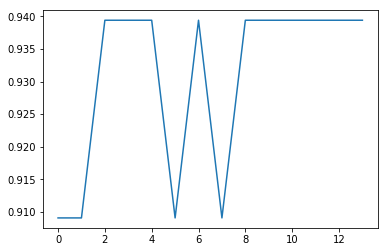

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(test_accuracies)